## Prerequisities

In [ ]:
# install prerequisities

import gdown
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import r2_score
from statsmodels.tsa.api import ARIMA
from sklearn.metrics import mean_squared_error

In [ ]:
# Load data from drive
def load_data(link, index= None):
  # Download data from gdrive
  meta_url = 'https://drive.google.com/uc?export=download&confirm=pbef&id='
  url = meta_url + link
  output = 'data.xlsx'
  gdown.download(url, output, quiet=True)
  data = pd.read_excel(output)
  return data

## Prepare Formal Employer Data

In [ ]:
# Prepare the employment data
emp_df = load_data('13ZCJJ8QCcMc-encEBvbmY1Cp_mPOcAkY')
emp_df.drop(['Series Code','Country Code'], axis=1, inplace=True)
emp_df.columns = ['Series', 'Country'] + [str(i) for i in range(2003,2019)]

In [ ]:
emp_df.tail(1)

,Series,Country,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
111,"Self-employed, male (% of male employment) (mo...",Zimbabwe,50.139999,50.16,50.830002,52.18,54.560001,58.48,57.66,56.93,56.0,56.509998,56.84,56.689999,57.060001,57.48,57.25,56.98


In [ ]:
# Melt the data to transform data structure
melted_emp_df = pd.melt(emp_df, id_vars=['Series', 'Country'], 
                    var_name='Year', value_name='Value')
melted_emp_df.tail()

,Series,Country,Year,Value
1787,"Self-employed, male (% of male employment) (mo...",Senegal,2018,59.840000
1788,"Self-employed, male (% of male employment) (mo...",Tanzania,2018,80.720001
1789,"Self-employed, male (% of male employment) (mo...",Uganda,2018,71.959999
1790,"Self-employed, male (% of male employment) (mo...",Zambia,2018,66.660004
1791,"Self-employed, male (% of male employment) (mo...",Zimbabwe,2018,56.980000


In [ ]:
# Pivot the data with the rows: year and columns: indicator

pivoted_emp_df = pd.pivot_table(melted_emp_df, index=['Country','Year'], 
                            columns='Series', values='Value')
pivoted_emp_df.columns = ['Informal female', 'Informal male', 
                          'Formal female', 'Formal male']
pivoted_emp_df = pivoted_emp_df.reset_index()
pivoted_emp_df.head()

,Country,Year,Informal female,Informal male,Formal female,Formal male
0,Armenia,2003,53.880001,43.919998,46.119999,56.080002
1,Armenia,2004,53.020000,43.160000,46.980000,56.840000
2,Armenia,2005,52.200001,41.939999,47.799999,58.060001
3,Armenia,2006,50.889999,40.590000,49.110001,59.410000
4,Armenia,2007,49.169998,38.860001,50.840000,61.139999


In [ ]:
pivoted_emp_df.to_excel("Clean_formal_employer.xlsx", index=False)

## Prepare Decision Making Factor Data

In [ ]:
df_factor = load_data("1tFGpPXsRu4VSi0NO_nrSKjRe0xQCgzyn") # Decision making factor
df_factor.head(1) # Preview

Unknown extension is not supported and will be removed


,Series Name,Series Code,Country Name,Country Code,2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],2008 [YR2008],2009 [YR2009],2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018]
0,"Employers, female (% of female employment) (mo...",SL.EMP.MPYR.FE.ZS,Armenia,ARM,0.05,0.06,0.07,0.08,0.09,0.09,0.09,0.13,0.29,0.23,0.18,0.56,0.34,0.4,0.52,0.31


In [ ]:
# Split dataframe to 9 different indicators
# These indicators have a high correlation with decision making
# And will be used in imputation regression
factors = {"employers":0, "literacy":0, "parliement":0, "ministerial":0, "primary":0, 
            "secondary":0, "tertiary":0, "startup_proc":0, "time_business":0}

for key ,n in zip(factors.keys(),range(df_factor['Series Name'].nunique())):
    factor = df_factor['Series Name']
    factors[key] = df_factor[factor == factor.unique()[n]]

In [ ]:
# These indicators have some missing value
for i,j in factors.items():
  print(i,":",j.isnull().sum().sum())

employers : 0
literacy : 33
parliement : 323
ministerial : 15
primary : 229
secondary : 208
tertiary : 236
startup_proc : 132
time_business : 33


In [ ]:
# There is no row that is empty on all of it
df_factor[df_factor.iloc[:,4:].isnull().sum(axis=1)==df_factor.shape[1]-4]

,Series Name,Series Code,Country Name,Country Code,2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],2008 [YR2008],2009 [YR2009],2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018]


In [ ]:
# Apply iterative imputer with linear regression to impute missing value
imputed_factors = {}

for key,value in factors.items():
  tmp = value.iloc[:,4:].T
  imp_mean = IterativeImputer(LinearRegression(), random_state=0, max_iter=1000,
                              min_value=0, max_value=100)
  clean_tmp = pd.DataFrame(imp_mean.fit_transform(tmp), 
                          columns=tmp.columns, 
                          index=tmp.index)
  imputed_factors[key] = clean_tmp

[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.


In [ ]:
# Merge all imputed dataframe
imputed_value = pd.concat([imputed_factors['employers'].T, 
                imputed_factors['literacy'].T, imputed_factors['parliement'].T, 
                imputed_factors['ministerial'].T, imputed_factors['primary'].T,
                imputed_factors['secondary'].T, imputed_factors['tertiary'].T,
                imputed_factors['startup_proc'].T, imputed_factors['time_business'].T])
imputed_df_factor = pd.concat([df_factor.iloc[:,:4], imputed_value], axis=1)

In [ ]:
# Save it
imputed_df_factor.to_excel("imputed_decision_making_factor.xlsx", index=False)

## Prepare Decision Making Data

In [ ]:
df_factor_clean = load_data("1wrGSl4DOW1Es5wrkoTqGa-pRPRGsGJwo") # Load imputed decision making factor
df = load_data("1PLb0Ayg5fRLQiBn2bD7J52m_T8ahjXKm") # Load decision making
df_all = pd.concat([df_factor_clean, df], ignore_index=True) # Merge it

Unknown extension is not supported and will be removed


In [ ]:
df_all.tail(1) # Preview

,Series Name,Series Code,Country Name,Country Code,2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],2008 [YR2008],2009 [YR2009],2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018]
923,"Women, Business and the Law: Mobility Indicato...",SG.LAW.INDX.MO,Zimbabwe,ZWE,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [ ]:
# No rows that contain all missing value
df[df.iloc[:,4:].isnull().sum(axis=1)==df.shape[1]-4]

,Series Name,Series Code,Country Name,Country Code,2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],2008 [YR2008],2009 [YR2009],2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018]


In [ ]:
# Split dataframe based on countries
countries = {}
for i in df['Country Name'].unique():
  countries[i] = df_all[df_all['Country Name']==i]

In [ ]:
# Apply iterative imputer to impute missing value with decision making factor

imputed_countries = {}

for key,value in countries.items():
  tmp = value.iloc[:,4:].T
  imp_mean = IterativeImputer(LinearRegression(), random_state=0, max_iter=1000,
                              min_value=0, max_value=100)
  clean_tmp = pd.DataFrame(imp_mean.fit_transform(tmp), 
                          columns=tmp.columns, 
                          index=tmp.index)
  imputed_countries[key] = clean_tmp.T

[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.


In [ ]:
# Example imputed data
temp = imputed_countries[list(imputed_countries.keys())[0]]
temp.head()

,2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],2008 [YR2008],2009 [YR2009],2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018]
0,0.050000,0.060000,0.070000,0.080000,0.090000,0.090000,0.090000,0.130000,0.290000,0.230000,0.180000,0.560000,0.340000,0.400000,0.520000,0.310000
1,99.689119,99.691432,99.686960,99.691262,99.696851,99.690515,99.691436,99.680781,99.690353,99.695075,99.688376,99.690998,99.688031,99.682833,99.677162,99.680177
2,4.580153,5.343511,5.343511,5.343511,9.160305,8.396947,9.160305,9.160305,8.396947,10.687023,10.687023,10.687023,10.687023,10.687023,18.095238,18.095238
3,9.876856,9.876856,11.114847,9.876856,9.876856,5.900000,9.876856,11.100000,9.876856,10.500000,9.876856,11.100000,11.100000,11.100000,9.876856,7.100000
4,83.048990,85.151363,82.180230,84.907010,89.249420,87.073452,86.938194,90.478953,95.761670,96.881210,95.294510,94.175950,93.291420,92.500960,91.915110,90.545800


In [ ]:
# Merge the countries dataframe into one
clean_df = imputed_countries[list(imputed_countries.keys())[0]]
for key,value in list(imputed_countries.items())[1:]:
  clean_df = clean_df.append(pd.DataFrame(value, columns=clean_df.columns))

In [ ]:
# Split into the only imputed decision making
imputed_decision_making = pd.merge(df_all.iloc[:,:4], clean_df, left_index=True, right_index=True)[252:]
imputed_decision_making = imputed_decision_making.sort_values(by=['Country Name','Series Name'])
imputed_decision_making.head(1)

,Series Name,Series Code,Country Name,Country Code,2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],2008 [YR2008],2009 [YR2009],2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018]
252,Decision maker about a woman's own health care...,SG.DMK.HLTH.HB.ZS,Armenia,ARM,7.987721,7.465325,7.6,6.876721,5.854465,6.016163,5.030415,4.5,2.971544,3.340955,3.154099,3.083432,3.110971,2.6,1.946455,1.540362


In [ ]:
# Exclude row that contain this code because we won't use it
exclude = ["SG.DMK.HLTH.OT.ZS", "SG.DMK.HLTH.SE.ZS",
           "SG.DMK.VISI.OT.ZS", "SG.DMK.VISI.SE.ZS",
           "SG.DMK.PRCH.OT.ZS", "SG.DMK.PRCH.SE.ZS",
           "SG.DMK.DPCH.FN.ZS"]
imputed_decision_making = imputed_decision_making[~imputed_decision_making['Series Code'].isin(exclude)]

In [ ]:
# Save it
imputed_decision_making.to_excel("imputed_decision_making.xlsx", index=False) 

## Process Decision Making Data

In [ ]:
imputed_decision_making = load_data("1eGWaYuIFaj1JF7jPuJLf0Alcqbnljztf") # Imputed decision making

Unknown extension is not supported and will be removed


In [ ]:
imputed_decision_making.tail(1)

,Series Name,Series Code,Country Name,Country Code,2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],2008 [YR2008],2009 [YR2009],2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018]
475,"Women, Business and the Law: Mobility Indicato...",SG.LAW.INDX.MO,Zimbabwe,ZWE,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [ ]:
# Split the dataframe that contains series name decision maker
process_df = imputed_decision_making[imputed_decision_making['Series Name']\
                                     .str.contains("Decision maker")]
process_df['Series Code'] = process_df['Series Code'].str[:-6] # Shorten series code


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# The indicator sum must be 100, if it is not 100 , we will process it
# We group by name and code and sum it
tmp = (process_df.groupby(['Country Name','Series Code'])[process_df.columns[4:]].sum()).reset_index()
tmp.columns = ['Country Name','Series Code'] + ['Total '+str(i) for i in range(2003,2019)]
tmp = pd.concat([tmp for i in range(3)], ignore_index=True).sort_values(by=['Country Name','Series Code'])

In [ ]:
# Standardize the indicator with sum to 100
standardize_df = pd.DataFrame(process_df.iloc[:,4:].values/tmp.iloc[:,2:].values*100, 
                               columns=process_df.iloc[:,4:].columns)
standardize_df = pd.concat([imputed_decision_making[imputed_decision_making['Series Name'].str\
                            .contains("Decision maker")].reset_index(drop=True)\
                            .iloc[:,:4],standardize_df],axis=1)
standardize_df = pd.concat([imputed_decision_making[imputed_decision_making['Series Code']\
                             .isin(["SG.VAW.REAS.ZS","SG.LAW.INDX.MR","SG.LAW.INDX.MO"])],
                             standardize_df])
standardize_df = pd.concat([imputed_decision_making[imputed_decision_making['Series Name'].str\
                            .contains("Women participating")],
                             standardize_df]).sort_values(by=['Country Name','Series Name'])

standardize_df.head()

,Series Name,Series Code,Country Name,Country Code,2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],2008 [YR2008],2009 [YR2009],2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018]
0,Decision maker about a woman's own health care...,SG.DMK.HLTH.HB.ZS,Armenia,ARM,7.954604,7.624269,7.794872,7.020363,5.768802,6.376112,5.111847,4.559271,2.905030,2.794120,2.576851,2.648035,2.823902,2.636917,1.758326,1.823633
1,Decision maker about a woman's own health care...,SG.DMK.HLTH.WF.ZS,Armenia,ARM,33.875563,35.788608,34.153846,28.376986,21.965737,25.125584,20.637859,19.148936,19.504959,20.170085,22.958984,24.461449,29.242618,28.397566,22.532840,31.488574
2,Decision maker about a woman's own health care...,SG.DMK.HLTH.WH.ZS,Armenia,ARM,58.169833,56.587123,58.051282,64.602652,72.265461,68.498304,74.250295,76.291793,77.590011,77.035795,74.464165,72.890516,67.933480,68.965517,75.708835,66.687793
3,Decision maker about a woman's visits to her f...,SG.DMK.VISI.HB.ZS,Armenia,ARM,8.184104,7.921424,7.959641,7.107316,6.024526,6.312088,5.385531,4.907306,3.767840,4.119928,4.120061,4.142967,4.340213,3.881279,3.225282,3.133291
4,Decision maker about a woman's visits to her f...,SG.DMK.VISI.WF.ZS,Armenia,ARM,13.996048,14.931040,14.237668,12.411880,10.533510,11.549129,10.350202,10.032715,10.783107,10.926026,12.014511,12.582855,14.379541,14.269406,12.295661,15.969965


In [ ]:
# Save the clean decision making
standardize_df.to_excel("Clean_decision_making.xlsx", index=False)

## Transform Decision Making Data

In [ ]:
clean_decision_making = load_data("1XWIKfYJcDBBJCd4Rx-lFUGQ0WLVEWL7F") # Cleaned decision making
clean_decision_making.drop(['Series Code','Country Code'], axis=1, inplace=True)
clean_decision_making.columns = ['Series', 'Country'] + [str(i) for i in range(2003,2019)]

Unknown extension is not supported and will be removed


In [ ]:
clean_decision_making.tail(1)

,Series,Country,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
475,"Women, Business and the Law: Mobility Indicato...",Zimbabwe,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [ ]:
# Melt the data to be transformed to another data structure
melted_df = pd.melt(clean_decision_making, id_vars=['Series', 'Country'], 
                    var_name='Year', value_name='Value')
melted_df.tail()

,Series,Country,Year,Value
7611,Women participating in own health care decisio...,Zimbabwe,2018,76.506525
7612,Women participating in the three decisions (ow...,Zimbabwe,2018,79.964010
7613,Women who believe a husband is justified in be...,Zimbabwe,2018,38.602836
7614,"Women, Business and the Law: Marriage Indicato...",Zimbabwe,2018,80.000000
7615,"Women, Business and the Law: Mobility Indicato...",Zimbabwe,2018,100.000000


In [ ]:
# Pivot the data with rows: year and columns: indicator, and rename the columns

pivoted_df = pd.pivot_table(melted_df, index=['Country','Year'], 
                            columns='Series', values='Value')
pivoted_df.columns = ['Health decision: husband','Health decision: wife','Health decision: jointly',
                      'Visit decision: husband','Visit decision: wife','Visit decision: jointly',
                      'Purchase decision: husband','Purchase decision: wife','Purchase decision: jointly',
                      'Visit participation', 'Purchase participation',
                      'None participation', 'Health participation', 'All participation',
                      'Beating wife', 'Marriage score', 'Mobility score']
pivoted_df = pivoted_df.reset_index()
pivoted_df.head()

,Country,Year,Health decision: husband,Health decision: wife,Health decision: jointly,Visit decision: husband,Visit decision: wife,Visit decision: jointly,Purchase decision: husband,Purchase decision: wife,Purchase decision: jointly,Visit participation,Purchase participation,None participation,Health participation,All participation,Beating wife,Marriage score,Mobility score
0,Armenia,2003,7.954604,33.875563,58.169833,8.184104,13.996048,81.449924,13.428266,25.640579,57.428238,86.635522,75.801956,5.418878,90.356630,71.309578,23.243818,80.0,100.0
1,Armenia,2004,7.624269,35.788608,56.587123,7.921424,14.931040,83.341575,13.546999,24.418831,56.201414,87.008241,75.780843,5.170527,90.025250,70.738159,22.487122,80.0,100.0
2,Armenia,2005,7.794872,34.153846,58.051282,7.959641,14.237668,83.295964,13.071201,24.442083,57.279490,87.000000,76.800000,5.200000,89.900000,71.600000,22.100000,80.0,100.0
3,Armenia,2006,7.020363,28.376986,64.602652,7.107316,12.411880,85.195641,10.487837,21.930142,63.079471,88.251409,80.488663,4.511838,91.000906,75.274737,18.049168,80.0,100.0
4,Armenia,2007,5.768802,21.965737,72.265461,6.024526,10.533510,86.144927,7.662980,19.327260,70.377934,89.815449,83.493757,3.630303,93.289386,79.240723,13.649558,80.0,100.0


In [ ]:
pivoted_df.to_excel("Final_decision_making.xlsx", index=False)

## Forecast Woman Participation

In [ ]:
final_df = load_data("1w-YMkDywP_Wcz-cVbb3GpkKn85f-f8Rk") # Participation data to be forecasted
forecast_df = final_df[['Country','Year','All participation','None participation']]
forecast_df.head(2)

,Country,Year,All participation,None participation
0,Armenia,2003,71.309578,5.418878
1,Armenia,2004,70.738159,5.170527


In [ ]:
# Filter the data 
indonesia = forecast_df.query('Country=="Indonesia"')
indonesia_all = indonesia[["Year","All participation"]].set_index("Year")
indonesia_none = indonesia[["Year","None participation"]].set_index("Year")

In [ ]:
# Stationary Test

for i,j in [(indonesia_all,'All participation:'), (indonesia_none,'None participation:')]:
  result = adfuller(i.iloc[:,0].dropna())
  pvalue = result[1]
  if pvalue < 0.05:
      print(j,'Stationary')
  else:
      print(j,'Not Stationary')

All participation: Stationary
None participation: Not Stationary


pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


invalid value encountered in sqrt
invalid value encountered in double_scalars


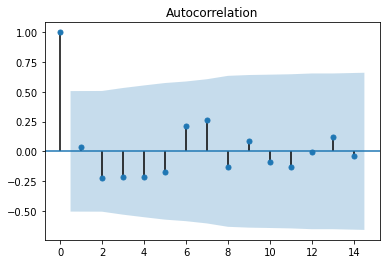

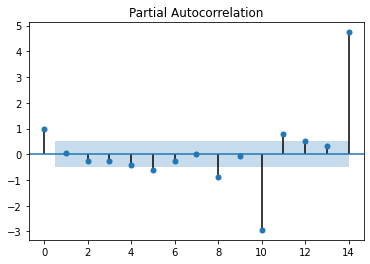

In [ ]:
# Plot the autocorrelation and the partial autocorrelation
plot_acf(indonesia_all.diff().dropna(), lags=indonesia_all.shape[0]-2)
plot_pacf(indonesia_all.diff().dropna(), lags=indonesia_all.shape[0])
plt.show()

invalid value encountered in sqrt
invalid value encountered in double_scalars


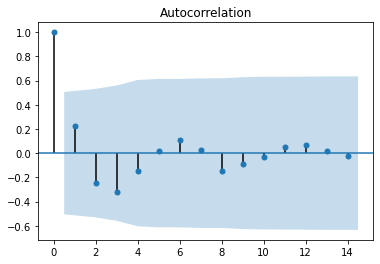

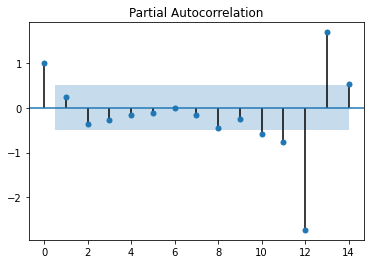

In [ ]:
plot_acf(indonesia_none.diff().dropna(), lags=indonesia_none.shape[0]-2)
plot_pacf(indonesia_none.diff().dropna(), lags=indonesia_none.shape[0])
plt.show()

### All participation

In [ ]:
# Loop for searching the fit parameter AR & MA with RMSE metrics
data_array = indonesia_all.values

d=0
for p in range(6):
        for q in range(4):
            try:
              step = 9
              X_train, X_test = data_array[:-step], data_array[-step:]
              mod = ARIMA(X_train, order=(p,d,q))
              res = mod.fit()
              print((p,d,q),round(mean_squared_error(X_test, 
                                                     res.forecast(steps=step)[0], squared=False),3))
            except:
              pass

(0, 0, 0) 0.97
(0, 0, 1) 0.992
(1, 0, 0) 0.973


divide by zero encountered in log
divide by zero encountered in log


(2, 0, 0) 0.987
(2, 0, 1) 0.995


divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
invalid value encountered in double_scalars


(3, 0, 0) 0.993


divide by zero encountered in log


(3, 0, 1) 1.064


divide by zero encountered in log
Inverting hessian failed, no bse or cov_params available
invalid value encountered in sqrt
divide by zero encountered in log


(3, 0, 2) 1.015
(4, 0, 1) 1.184


Inverting hessian failed, no bse or cov_params available


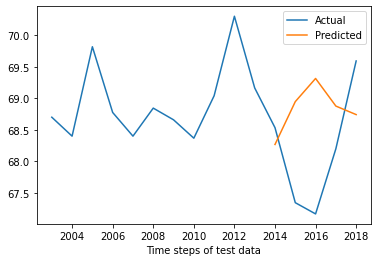

In [ ]:
# Evaluate the ARMA model
step = 5
X_train, X_test = data_array[:-step], data_array[-step:]
mod = ARIMA(X_train, order=(3,0,0))
res = mod.fit()

plt.plot(indonesia_all)  
plt.plot(pd.Series(res.forecast(steps=step)[0], index=indonesia_all[-step:].index))
plt.legend(['Actual', 'Predicted'])
plt.xlabel('Time steps of test data')
plt.show()

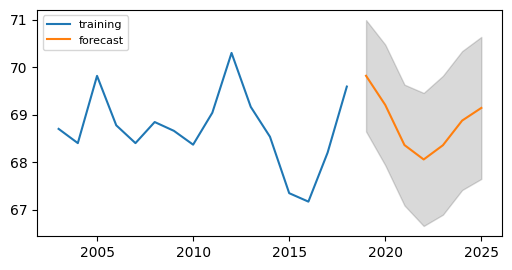

In [ ]:
# Forecast the all participation until 2025 with ARMA
train = indonesia_all.iloc[:,0].values

model = ARIMA(train, order=(3, 0, 0))  
fitted = model.fit()  

# Forecast
step=7
fc, se, conf = fitted.forecast(step, alpha=0.05)  # 95% conf

# Make as pandas series
idx = list(range(max(indonesia_all.index)+1, max(indonesia_all.index)+step+1))
fc_series_all = pd.Series(fc, idx)
lower_series_all = pd.Series(conf[:, 0], idx)
upper_series_all = pd.Series(conf[:, 1], idx)

# Plot
plt.figure(figsize=(6,3), dpi=100)
plt.plot(pd.Series(train, index=indonesia_all.index), label='training')
plt.plot(fc_series_all, label='forecast')
plt.fill_between(lower_series_all.index, lower_series_all, upper_series_all, 
                 color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=8)
plt.show()

### None participation

In [ ]:
# Loop for searching the fit parameter AR, I & MA with RMSE metrics
data_array = indonesia_none.values

d=0
for p in range(4):
    for d in range(2):
        for q in range(4):
            try:
              step = 3
              X_train, X_test = data_array[:-step], data_array[-step:]
              mod = ARIMA(X_train, order=(p,d,q))
              res = mod.fit()
              print((p,d,q),round(mean_squared_error(X_test, 
                                                     res.forecast(steps=step)[0], squared=False),3))
            except:
              pass

(0, 0, 0) 0.359
(0, 0, 1) 0.279
(0, 1, 0) 0.321
(0, 1, 1) 0.262


Inverting hessian failed, no bse or cov_params available


(0, 1, 2) 1.029
(0, 1, 3) 0.917
(1, 0, 0) 0.302
(1, 0, 1) 0.253
(1, 0, 2) 0.258
(1, 0, 3) 0.491
(1, 1, 0) 0.272
(2, 0, 0) 0.241
(2, 0, 1) 0.24


Inverting hessian failed, no bse or cov_params available


(2, 0, 2) 0.232
(2, 0, 3) 0.512
(2, 1, 0) 0.4
(3, 0, 0) 0.24
(3, 0, 1) 0.43
(3, 0, 2) 0.45
(3, 0, 3) 0.507


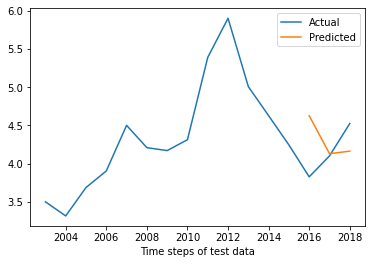

In [ ]:
# Evaluate the ARIMA model
step = 3
X_train, X_test = data_array[:-step], data_array[-step:]
mod = ARIMA(X_train, order=(3,0,3))
res = mod.fit()

plt.plot(indonesia_none)  
plt.plot(pd.Series(res.forecast(steps=step)[0], index=indonesia_none[-step:].index))
plt.legend(['Actual', 'Predicted'])
plt.xlabel('Time steps of test data')
plt.show()

Inverting hessian failed, no bse or cov_params available


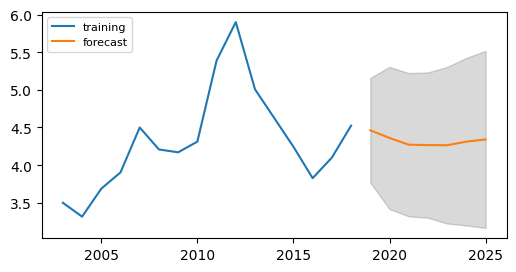

In [ ]:
# Forecast the none participation until 2025 with ARIMA
train = indonesia_none.iloc[:,0].values

model = ARIMA(train, order=(3, 0, 3))  
fitted = model.fit()  

# Forecast
step=7
fc, se, conf = fitted.forecast(step, alpha=0.05)  # 95% conf

# Make as pandas series
idx = list(range(max(indonesia_none.index)+1, max(indonesia_none.index)+step+1))
fc_series_none = pd.Series(fc, idx)
lower_series_none = pd.Series(conf[:, 0], idx)
upper_series_none = pd.Series(conf[:, 1], idx)

# Plot
plt.figure(figsize=(6,3), dpi=100)
plt.plot(pd.Series(train, index=indonesia_none.index), label='training')
plt.plot(fc_series_none, label='forecast')
plt.fill_between(lower_series_none.index, lower_series_none, upper_series_none, 
                 color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Save Forecasting

In [ ]:
# Merge all participation data with bounds
forecast_all = pd.Series(fc_series_all, name='Forecast')
real_all = indonesia_all.iloc[:,0].rename('Actual')
lb_all = pd.Series(lower_series_all, name='Lower')
ub_all = pd.Series(upper_series_all, name='Upper')
pd.concat([real_all, forecast_all, lb_all, ub_all], axis=1).\
          to_excel('All_forecast.xlsx')

In [ ]:
# Merge none participation data with bounds
forecast_none = pd.Series(fc_series_none, name='Forecast')
real_none = indonesia_none.iloc[:,0].rename('Actual')
lb_none = pd.Series(lower_series_none, name='Lower')
ub_none = pd.Series(upper_series_none, name='Upper')
pd.concat([real_none, forecast_none, lb_none, ub_none], axis=1).\
          to_excel('None_forecast.xlsx')

## Correlation with Decision Making

In [ ]:
gender = load_data('1lCrYzpGmOWwaLnYDJvdW6v6gc8CerQVl') # Decision Making Aspects data

In [ ]:
# Concat the female and male data to find correlation
female = gender[gender.columns[gender.columns.str.endswith('_f')]]
male = gender[gender.columns[gender.columns.str.endswith('_m')]]
female.columns = np.arange(female.shape[1]).astype(str)
male.columns = np.arange(male.shape[1]).astype(str)

gender_df = pd.DataFrame(pd.concat([female, male], axis=0, ignore_index=True))
gender_df.columns = gender.columns[gender.columns.str.contains('_f')].str[:-2]

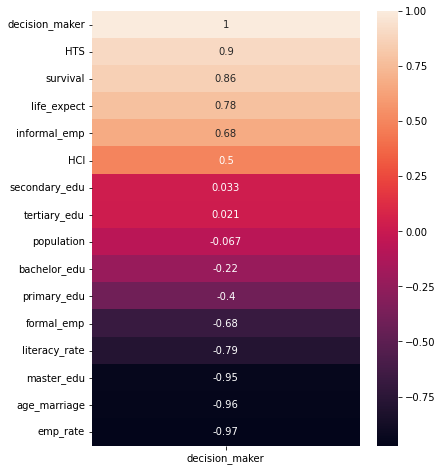

In [ ]:
# Correlation on decision maker with other aspects
plt.figure(figsize=(6,8))
sns.heatmap(gender_df.corr()[['decision_maker']].sort_values(
    by='decision_maker', ascending=False), annot=True)

In [ ]:
# Calculate the pearson correlation with p-value stastical significance
new_df = {}
for i in np.setdiff1d(gender_df.columns.values, ['decision_maker']):
  new_df[i] = pearsonr(gender_df['decision_maker'],gender_df[i])
new_df = pd.DataFrame(new_df, index=['decision_maker','p_value']).T

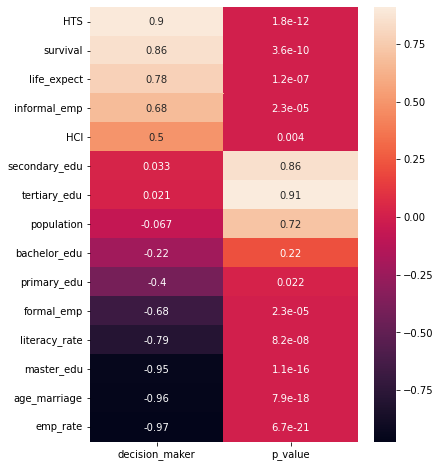

In [ ]:
# Show the correlation and p-value
plt.figure(figsize=(6,8))
sns.heatmap(new_df.sort_values(
    by='decision_maker', ascending=False), annot=True)

In [ ]:
new_df.to_excel("Correlation.xlsx")